# IBCS Scaling Compliance Classifier (MobileNetV2)

Goal:
We have dashboard images that are either **Compliant** or **Not Compliant** with IBCS scaling rules.

We will:
1. Load all images into Python.
2. Use **MobileNetV2**, a pre-trained deep learning model that can recognize visual patterns.
3. Train it to classify each image as "Compliant" or "Not Compliant".
4. Test the model and make predictions.

In [14]:

import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import copy, pathlib, math


import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## Load the dataset

We’ll load each image, resize it to 224×224 (MobileNetV2’s preferred size),
and assign:
- label **1** = Compliant  
- label **0** = Not Compliant

In [15]:
import numpy

size = 224

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return numpy.array(img)

def load_labelled_images(path, size):
    labels = []
    files = []
    for file_info in pathlib.Path(path).glob("**/*.jpg"):
        labels.append(file_info.parts[-2])
        files.append(str(file_info))
    imgs = numpy.array([load_image(f, size) for f in files])
    return imgs, numpy.array(labels)   

images, labels = load_labelled_images("../Scaling _dataset", size)
print("Loaded", len(images), "images in the following", len(numpy.unique(labels)), "classes:")
for label in numpy.unique(labels):
    print(" ", label)

Loaded 26 images in the following 2 classes:
  Compliant
  Not Compliant


## Sampling the data

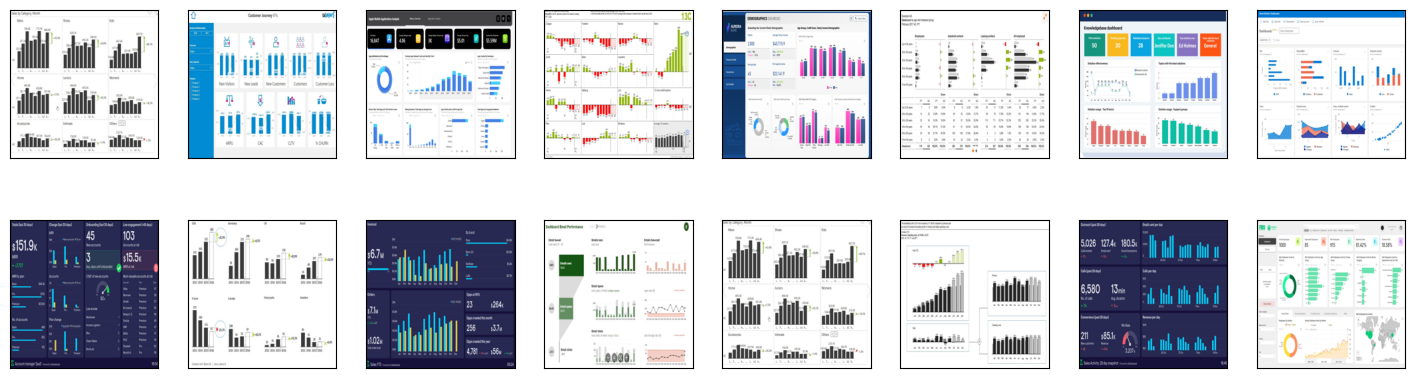

In [16]:
sample_size = 16

plotimgs = copy.deepcopy(images)
numpy.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(x)  # x is already (224,224,3)
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

## Split into training and testing data

We’ll use 80% of the images to train the model and 20% to test it.

This is the same concept as `train_test_split` in basic ML.


In [17]:
from sklearn.model_selection import train_test_split

label_to_num = {"Compliant": 1, "Not Compliant": 0}
labels = np.array([label_to_num[label] for label in labels])

# Train/test split (your version preserved)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=.3, random_state=42, stratify=labels
)

# Function to print class counts
def print_class_counts(y, set_name):
    classes, counts = np.unique(y, return_counts=True)
    print(f"{set_name} set:")
    for cls, count in zip(classes, counts):
        name = "Compliant" if cls == 1 else "Not Compliant"
        print(f"  {name}: {count}")
    print()

print_class_counts(y_train, "Train")
print_class_counts(y_test, "Test")

Train set:
  Not Compliant: 11
  Compliant: 7

Test set:
  Not Compliant: 5
  Compliant: 3



## Step 4: Preprocess the images for MobileNetV2

Neural networks expect the pixel values in a certain range.

`preprocess_input()` scales pixel values between -1 and 1, which helps the model learn correctly.

In [18]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

## Build the MobileNetV2 model

We use a **pre-trained MobileNetV2** as our base.

Steps:
1. Load MobileNetV2 without its last layer (`include_top=False`).
2. Freeze it (so we keep its pre-learned knowledge from ImageNet).
3. Add our own small output layer to classify between 2 categories:
   - 1 neuron with sigmoid activation (for binary classification).

In [19]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the base model
base_model.trainable = False

# Build the classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # convert features to a single vector
    layers.Dense(1, activation='sigmoid')  # output 0-1 for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train the model

We train it just like in normal ML (`fit()` method).

- **Epochs**: how many times the model sees the full training data.
- **Batch size**: how many images are processed at once.

In [27]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_data=(X_test, y_test)
)

Epoch 1/50


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 0.1121 - val_accuracy: 0.8750 - val_loss: 0.3180
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0996 - val_accuracy: 0.8750 - val_loss: 0.3128
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0880 - val_accuracy: 0.8750 - val_loss: 0.3068
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 0.0817 - val_accuracy: 0.8750 - val_loss: 0.3039
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0732 - val_accuracy: 0.8750 - val_loss: 0.2984
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0677 - val_accuracy: 0.8750 - val_loss: 0.2975
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 0.0617 - val_accuracy: 0.8750 - val_loss: 0.2952
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 0.8750 - val_loss: 0.2941
Epo

## Check how well it did

We can check:
- Test accuracy
- Training vs validation accuracy plots

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8750 - loss: 0.2844
Test accuracy: 0.875


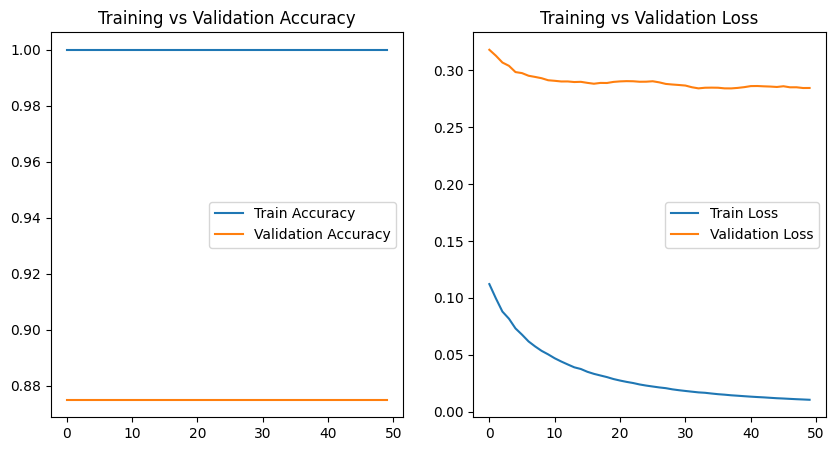

In [32]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

### Testing 

In [23]:
def classify_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))
    arr = np.array(img).astype("float32")
    arr = np.expand_dims(arr, axis=0)  # add batch dimension
    arr = preprocess_input(arr)

    prob = model.predict(arr)[0][0]
    label = "Compliant" if prob > 0.5 else "Not Compliant"
    return label, prob

# Try it on one of your dataset images:
test_img = "../Scaling _dataset/Compliant/Scaling_compliant_002.jpg"
label, confidence = classify_image(test_img)
print("Prediction:", label)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Compliant
Confidence: 0.97953236


## Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


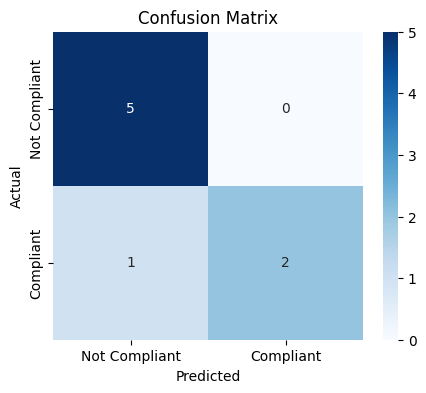

Classification Report:

               precision    recall  f1-score   support

Not Compliant       0.83      1.00      0.91         5
    Compliant       1.00      0.67      0.80         3

     accuracy                           0.88         8
    macro avg       0.92      0.83      0.85         8
 weighted avg       0.90      0.88      0.87         8



In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions (0 or 1)
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["Not Compliant", "Compliant"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report (precision, recall, f1)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels))

In [34]:
import os

save_dir = "../Checkpoints"
os.makedirs(save_dir, exist_ok=True)

mobilenet_path = os.path.join(save_dir, "mobilenet.keras")
model.save(mobilenet_path)
print("Model saved at:", mobilenet_path)


Model saved at: ../Checkpoints\mobilenet.keras
